In [5]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from plot_util import *
from liftpose.preprocess import add_roots, unNormalize
sns.set()

#windows
#par_train = {'data_dir' : r'\Users\NeLy\Desktop\mouse_prism\mouse_prism', # change the path 
#       'out_dir'        : 'out',
#       'train_subjects' : ['G6AE6','G6AE2','G6AE3','G6AE5'],
#       'test_subjects'  : ['G6AE1'],
#       'actions'        : ['control']}

#mac/ubuntu
par_train = {'data_dir' : '/data/LiftPose3D/mouse_prism', # change the path 
       'out_dir'        : '/data/LiftPose3D/mouse_prism/out',
       'train_subjects' : ['G6AE6','G6AE2','G6AE3','G6AE5'],
       'test_subjects'  : ['G6AE1'],
       'actions'        : ['control']}

# Loading LP3D Predictions

In [8]:
#LiftPose3D prediction
data = torch.load(os.path.join(par_train['out_dir'], 'test_results.pth.tar'))

tar_mean = torch.load(os.path.join(par_train['out_dir'], 'stat_3d.pth.tar'))['mean']
tar_std = torch.load( os.path.join(par_train['out_dir'], 'stat_3d.pth.tar'))['std']
targets_1d = torch.load( os.path.join(par_train['out_dir'], 'stat_3d.pth.tar'))['targets_3d']
tar_offset = np.vstack(torch.load(os.path.join(par_train['out_dir'], 'stat_3d.pth.tar'))['offset'].values())
good_keypts = add_roots(data['good_keypts'],targets_1d,len(tar_mean)).astype(bool)

inp_mean = torch.load(os.path.join(par_train['out_dir'], 'stat_2d.pth.tar'))['mean']
inp_std = torch.load(os.path.join(par_train['out_dir'], 'stat_2d.pth.tar'))['std']
targets_2d = torch.load(os.path.join(par_train['out_dir'], 'stat_2d.pth.tar'))['targets_2d']
inp_offset = np.vstack(torch.load(os.path.join(par_train['out_dir'], 'stat_2d.pth.tar'))['offset'].values())

tar = unNormalize(data['target'], tar_mean[targets_1d], tar_std[targets_1d])
tar = add_roots(tar,targets_1d,len(tar_mean))
tar += tar_offset
out = unNormalize(data['output'], tar_mean[targets_1d], tar_std[targets_1d])
out = add_roots(out,targets_1d,len(tar_mean))
out += tar_offset
inp = unNormalize(data['input'], inp_mean[targets_2d], inp_std[targets_2d])
inp = add_roots(inp,targets_2d,len(inp_mean))
inp += inp_offset

chosen_keypts = [0,1,2,3,4,5,6]
inp[inp==0]=np.NaN
out[out==0]=np.NaN
tar[tar==0]=np.NaN

inp = inp[:462]
out = out[:462]
tar = tar[:462]

bottom_x, bottom_y = inp[:,::2], inp[:,1::2]
side_x, side_y = inp[:,::2], tar
side_x_pred, side_y_pred = inp[:,::2], out

bottom_x, bottom_y = bottom_x[:,chosen_keypts], bottom_y[:,chosen_keypts]
side_x, side_y = side_x[:,chosen_keypts], side_y[:,chosen_keypts]
side_x_pred, side_y_pred = side_x_pred[:,chosen_keypts], side_y_pred[:,chosen_keypts]
good_keypts = good_keypts[:,chosen_keypts]

poses = pickle.load(open(os.path.join(par_train['data_dir'], 'G6AE1_100_27_1_control_S3T12.pkl'), 'rb'))
index = pickle.load(open(os.path.join(par_train['data_dir'], 'G6AE1_100_27_1_control_S3T12.pkl'), 'rb'))["index"]

i = 0
img = plt.imread(os.path.join(par_train['data_dir'], 'img{:03d}.png'.format(index[i])))
s = img.shape
x_ind, y_ind = flat_to_xy(np.squeeze(poses["distort"]), img.shape[0], img.shape[1])

[PngImagePlugin.py:187]:DEBUG:STREAM b'IHDR' 16 13
[PngImagePlugin.py:187]:DEBUG:STREAM b'IDAT' 41 8192


<ipython-input-8-25282d457481>:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  tar_offset = np.vstack(torch.load(os.path.join(par_train['out_dir'], 'stat_3d.pth.tar'))['offset'].values())
<ipython-input-8-25282d457481>:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  inp_offset = np.vstack(torch.load(os.path.join(par_train['out_dir'], 'stat_2d.pth.tar'))['offset'].values())


# Loading Manual Annotations

In [10]:
d = pd.read_csv((os.path.join(par_train['data_dir'], 'ManualAnnotation.csv')))
d_np = d.to_numpy()
img_name_list = list()
kp = list()
for i in range(3, d_np.shape[0]):
    img_name_list.append(d_np[i][0])
    kp.append(d_np[i][1:])
kp = np.array(kp)
is_full = np.logical_not(pd.isnull(np.array(kp)).sum(axis=1).astype(np.bool))
kp = kp[is_full, :].astype(np.float32)
kp = kp.reshape(kp.shape[0], 6, 2)

img_name_list = np.array(img_name_list)[is_full]
img_name_list = [int(img_name.split('/')[-1].replace('img', '').replace('.png', '')) for img_name in img_name_list]

for kp_idx in range(kp.shape[0]):
    for k in range(6):
        pts = kp[kp_idx]
        x, y = pts[k, :].astype(int)
        try:
            x_und, y_und = flat_to_xy(np.where(np.logical_and(x_ind==y, y_ind==x))[0][0], s[0], s[1])
            kp[kp_idx, k, 0 ] = y_und
            kp[kp_idx, k, 1 ] = x_und
        except:
            kp[kp_idx, :] = 0
            continue
            
rot = [2, 4, 1, 3, 0, 5]
kp = kp[:, rot]

# Loading LocoMouse Annotations

In [11]:
kp_loco = np.zeros((517, 7, 2))
kp_loco[index, :, 0] = side_x
kp_loco[index, :, 1] = side_y
kp_loco_selected = kp_loco[img_name_list]

kp_pred = np.zeros((517, 7, 2))
kp_pred[index, :, 0] = side_x_pred
kp_pred[index, :, 1] = side_y_pred
kp_pred_selected = kp_pred[img_name_list]

(0.0, 50.0)

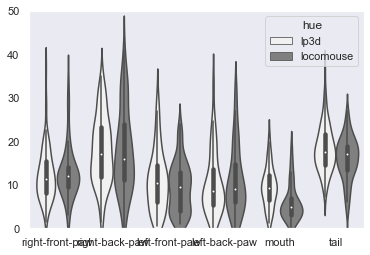

In [13]:
lp3d = np.zeros((104, 6, 2))

names_joint = ['mouth', 'left-front-paw', "right-front-paw", "left-back-paw",  "right-back-paw", "tail"]
names_joint_rot = np.array(names_joint)[rot]

err_norm = list()
err_joint = list()
err_hue = list()
for img_id in range(kp.shape[0]):
    if np.any(kp[img_id]==0) or np.any(kp_pred_selected[img_id]==0) or np.any(pd.isnull(kp[img_id])) or np.any(pd.isnull(kp_pred_selected[img_id])):
        continue
    for j_id in range(6):
        err_norm.append(np.sum(np.abs(kp[img_id][j_id]-kp_pred_selected[img_id][j_id])))
        err_joint.append(names_joint_rot[j_id])
        err_hue.append('lp3d')

for img_id in range(kp.shape[0]):
    if np.any(kp[img_id]==0) or np.any(kp_loco_selected[img_id]==0) or np.any(pd.isnull(kp[img_id])) or np.any(pd.isnull(kp_loco_selected[img_id])):
        continue
    for j_id in range(6):
        err_norm.append(np.sum(np.abs(kp[img_id][j_id]-kp_loco_selected[img_id][j_id])))
        err_joint.append(names_joint_rot[j_id])
        err_hue.append('locomouse')
        
d = pd.DataFrame({"err":err_norm, "joint": err_joint, "hue": err_hue})
q = d.quantile(q=0.95)
d = d.loc[d['err'] < q['err']]

#plt.figure(dpi=100)
plt.figure()
plt.grid(False)
sns.violinplot(x="joint" , y="err", hue='hue', data=d, color='gray')
plt.xlabel('')
plt.ylabel('')
plt.ylim([0,50])
#plt.savefig('/results/Figure_2G.png')